# Question 1

In [1]:
import pandas as pd
import time
import json

with open("band_gap_data.json", "r") as f:
    data = json.load(f)
df = pd.DataFrame(data)
df["temperature_K"] = pd.to_numeric(df["temperature_K"], errors="coerce")

#BOOLEAN
#Uses vectorized logical conditions to filter the entire DataFrame at once without looping.
temp = df["temperature_K"] > 50
crystal = df["crystallinity"] == "Polycrystalline"
method = df["exp_method"] == "Reflection"

start_mask = time.time()
filtered_mask = df[temp & crystal & method]
end_mask = time.time()

#FOR LOOP IAT
#Iterates through each row index and accesses individual cell values by their integer position for comparison.
start_iat = time.time()
rows_iat = []
for i in range(len(df)):
    if (
        df.iat[i, df.columns.get_loc("temperature_K")] > 50 and
        df.iat[i, df.columns.get_loc("crystallinity")] == "Polycrystalline" and
        df.iat[i, df.columns.get_loc("exp_method")] == "Reflection"
    ):
        rows_iat.append(df.iloc[i])
filtered_iat = pd.DataFrame(rows_iat)
end_iat = time.time()

#FOR LOOP ILOC
#Iterates through each row, retrieving the full row as a Series and then checking its column values against the conditions.
start_iloc = time.time()
rows_iloc = []
for i in range(len(df)):
    row = df.iloc[i]
    if (
        row["temperature_K"] > 50 and
        row["crystallinity"] == "Polycrystalline" and
        row["exp_method"] == "Reflection"
    ):
        rows_iloc.append(row)
filtered_iloc = pd.DataFrame(rows_iloc)
end_iloc = time.time()

print("Boolean rows", len(filtered_mask))
print("Forloop_iat rows", len(filtered_iat))
print("Forloop_iloc rows", len(filtered_iloc))
print()
print(f"Boolean duration: {end_mask - start_mask:.6f} s")
print(f"Forloop_iat duration: {end_iat - start_iat:.6f} s")
print(f"Forloop_iloc duration: {end_iloc - start_iloc:.6f} s")


Boolean rows 46
Forloop_iat rows 46
Forloop_iloc rows 46

Boolean duration: 0.000453 s
Forloop_iat duration: 0.030033 s
Forloop_iloc duration: 0.035631 s


# Question 2

In [2]:
import pandas as pd
bgdata = pd.read_json("band_gap_data.json")

##### I definitely used ChatGPT to help write this. Some bugs I fixed along the way: my code originally was having trouble converting all the numeric elements into floats. I made extra additions under step 4 that helped solved this issue, though I don't know if I fixed it perfectly. I also had a divide by zero error somewhere and I added a part in step 5 to address this. I also went through line by line and made comments to help me understand it better and explain some of the key features. 

Pearson correlation matrix (features + band_gap):
                           temperature_K  crys_Amorphous  \
temperature_K                   1.000000        0.105387   
crys_Amorphous                  0.105387        1.000000   
crys_Polycrystalline            0.094162       -0.084120   
crys_Single crystalline        -0.135267       -0.373406   
bgtype_Direct                   0.142324        0.005465   
bgtype_Excitonic               -0.198352       -0.072063   
bgtype_G6 to G8                -0.078609       -0.009251   
bgtype_Indirect                -0.001759        0.044938   
method_APW                      0.034383       -0.009251   
method_Absorption               0.021054        0.136746   
method_Electroreflection        0.098608       -0.033854   
method_Estimated                0.074062       -0.020788   
method_Magnetoabsorption       -0.289396       -0.041239   
method_Magnetoreflection       -0.174049       -0.018570   
method_Photoconduction         -0.092197       -0.

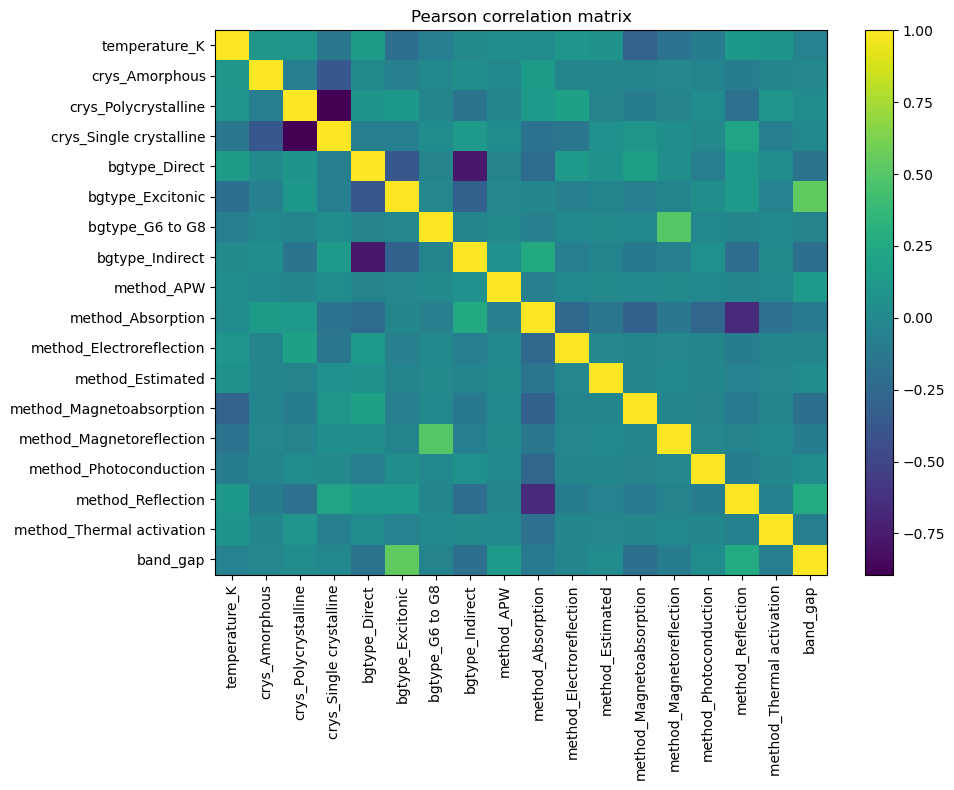

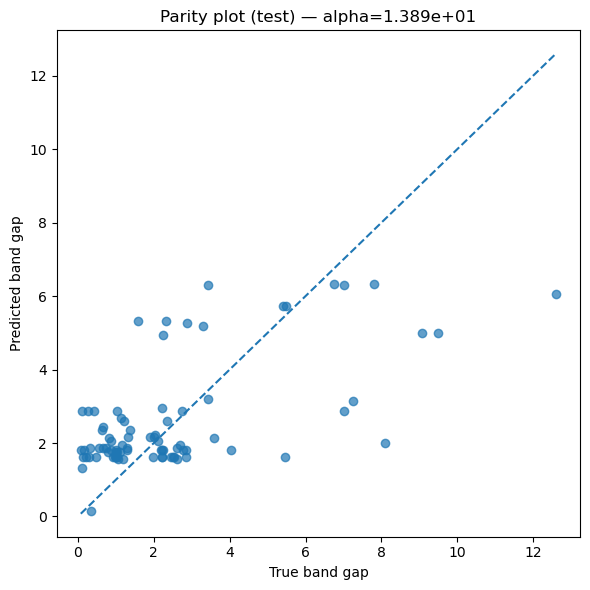

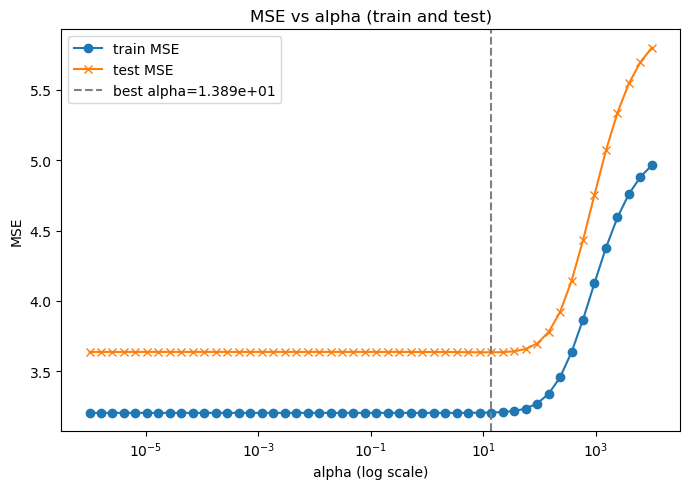

In [ ]:
# ridge_bg_analysis.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from math import isnan

def mse(y_true, y_pred):
    """Mean squared error."""
    return np.mean((y_true - y_pred) ** 2)

def ridge_closed_form(X, y, alpha, fit_intercept=True, regularize_intercept=False):
    """
    Closed-form ridge solution:
      w = (X^T X + alpha * I)^(-1) X^T y
    If fit_intercept, X should NOT include the constant column (function will add it).
    If regularize_intercept=False, the intercept is not regularized.
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    n, p = X.shape
    if fit_intercept:
        X_aug = np.hstack([np.ones((n, 1)), X])
    else:
        X_aug = X
    # Build regularization matrix
    P = X_aug.shape[1]
    I = np.eye(P)
    if fit_intercept and not regularize_intercept:
        I[0, 0] = 0.0
    A = X_aug.T.dot(X_aug) + alpha * I
    # solve A w = X^T y
    w = np.linalg.solve(A, X_aug.T.dot(y))
    return w.ravel(), X_aug  # return weights (including intercept if added) and augmented X

def predict_with_weights(X, w, fit_intercept=True):
    X = np.asarray(X, dtype=float)
    if fit_intercept:
        X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
    else:
        X_aug = X
    return X_aug.dot(w).ravel()

# 1) DATA

bgdata = bgdata.dropna(subset=['crystallinity', 'band_gap_type', 'exp_method', 'temperature_K', 'band_gap'])
# Keep only the relevant columns
bgdata = bgdata[['crystallinity', 'band_gap_type', 'exp_method', 'temperature_K', 'band_gap']].copy()
# Convert numeric columns to numeric types (coerce errors)
bgdata['temperature_K'] = pd.to_numeric(bgdata['temperature_K'], errors='coerce')
bgdata['band_gap'] = pd.to_numeric(bgdata['band_gap'], errors='coerce')
# Drop any rows that became NaN after conversion
bgdata = bgdata.dropna(subset=['temperature_K', 'band_gap']).reset_index(drop=True)

# 2) ONE-HOT
#turn each category into a vector (list of 0s and 1s)

crys_dummies = pd.get_dummies(bgdata['crystallinity'], prefix='crys')
bgtype_dummies = pd.get_dummies(bgdata['band_gap_type'], prefix='bgtype')
method_dummies = pd.get_dummies(bgdata['exp_method'], prefix='method')

# Combine features: temperature_K + all dummy columns
# Actually combining all the feature columns side by side (axis=1), with temperature as the independent variable
X_df = pd.concat([bgdata[['temperature_K']].reset_index(drop=True),
                  crys_dummies.reset_index(drop=True),
                  bgtype_dummies.reset_index(drop=True),
                  method_dummies.reset_index(drop=True)], axis=1)
y = bgdata['band_gap'].values  # TARGET, the value we want to predict

# Ensure all features are numeric
X_df = X_df.apply(pd.to_numeric, errors='coerce')

# Drop any rows that became NaN after conversion (just to be safe)
valid_rows = np.isfinite(X_df).all(axis=1) #keeps only finite rows, no infinite or undefined rows
X_df = X_df[valid_rows] 
y = y[valid_rows] #boolean mask


# 3) CORRELATION PLOT
#computes the Pearson correlation coefficient between every pair of columns
corr_df = pd.concat([X_df, bgdata[['band_gap']].reset_index(drop=True)], axis=1).corr(method='pearson')
print("Pearson correlation matrix (features + band_gap):")
print(corr_df)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr_df, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title('Pearson correlation matrix')
plt.tight_layout()
#plt.savefig('correlation_matrix.png', dpi=200)
#plt.close()
#print("Saved correlation matrix figure to 'correlation_matrix.png'")


# 4) TRAIN/TEST
rng = np.random.default_rng(seed=42)
n = X_df.shape[0]
indices = np.arange(n)
rng.shuffle(indices)
train_n = int(0.8 * n)
train_idx = indices[:train_n]
test_idx = indices[train_n:]

# Make absolutely sure all features are numeric floats
X = X_df.to_numpy(dtype=float)
y = np.asarray(y, dtype=float)

X_train_raw = X[train_idx]
y_train = y[train_idx]
X_test_raw = X[test_idx]
y_test = y[test_idx]

# 🔎 Sanity check: confirm dtype is float64 (not object)
print("X_train_raw dtype:", X_train_raw.dtype)
print("Example of any object values:", X_train_raw[0])

# -------------------------
# 5) STANDARDIZE
# -------------------------
# Now compute statistics safely
feat_mean = np.mean(X_train_raw, axis=0)
feat_std = np.std(X_train_raw, axis=0, ddof=0)

# avoid division by zero
feat_std_safe = np.where(feat_std == 0, 1.0, feat_std)
X_train = (X_train_raw - feat_mean) / feat_std_safe
X_test = (X_test_raw - feat_mean) / feat_std_safe

# 6) Loop over alphas and train ridge

alphas = np.logspace(-6, 4, num=50)  # from tiny to large regularization
train_mses = []
test_mses = []
timings = []

for alpha in alphas:
    t0 = time.time()
    w, X_aug_train = ridge_closed_form(X_train, y_train, alpha=alpha, fit_intercept=True, regularize_intercept=False)
    t1 = time.time()
    timings.append(t1 - t0)
    y_train_pred = predict_with_weights(X_train, w, fit_intercept=True)
    y_test_pred = predict_with_weights(X_test, w, fit_intercept=True)
    train_mses.append(mse(y_train, y_train_pred))
    test_mses.append(mse(y_test, y_test_pred))

train_mses = np.array(train_mses)
test_mses = np.array(test_mses)

# 7) OPTIMAL ALPHA (min test MSE)

best_idx = np.nanargmin(test_mses)
best_alpha = alphas[best_idx]
print(f"Optimal alpha (min test MSE): {best_alpha:.3e}  with test MSE = {test_mses[best_idx]:.6f}")

# Refit with best alpha to produce parity plot
w_best, _ = ridge_closed_form(X_train, y_train, alpha=best_alpha, fit_intercept=True, regularize_intercept=False)
y_test_pred_best = predict_with_weights(X_test, w_best, fit_intercept=True)
y_train_pred_best = predict_with_weights(X_train, w_best, fit_intercept=True)

# 8) PARITY PLOT (true vs predicted) for the test set

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_best, alpha=0.7)
minv = min(y_test.min(), y_test_pred_best.min())
maxv = max(y_test.max(), y_test_pred_best.max())
plt.plot([minv, maxv], [minv, maxv], linestyle='--')  # y=x line
plt.xlabel('True band gap')
plt.ylabel('Predicted band gap')
plt.title(f'Parity plot (test) — alpha={best_alpha:.3e}')
plt.tight_layout()
#plt.savefig('parity_alpha_opt.png', dpi=200)
#plt.close()
#print("Saved parity plot to 'parity_alpha_opt.png'")

# 9) MSE vs ALPHA

plt.figure(figsize=(7, 5))
plt.semilogx(alphas, train_mses, marker='o', label='train MSE')
plt.semilogx(alphas, test_mses, marker='x', label='test MSE')
plt.axvline(best_alpha, color='gray', linestyle='--', label=f'best alpha={best_alpha:.3e}')
plt.xlabel('alpha (log scale)')
plt.ylabel('MSE')
plt.title('MSE vs alpha (train and test)')
plt.legend()
plt.tight_layout()
#plt.savefig('mse_vs_alpha.png', dpi=200)
#plt.close()
#print("Saved MSE vs alpha plot to 'mse_vs_alpha.png'")

print("\nSummary metrics for best model:")
print(f" - best alpha: {best_alpha:.3e}")
print(f" - train MSE @ best alpha: {train_mses[best_idx]:.6f}")
print(f" - test MSE  @ best alpha: {test_mses[best_idx]:.6f}")
print(f" - average training solve time per alpha (s): {np.mean(timings):.6f}")


# 11) COEFFICIENTS
coef_names = ['intercept'] + list(X_df.columns)
coef_vals = np.hstack([w_best[0], w_best[1:]])  # w_best includes intercept at position 0
coef_table = pd.Series(coef_vals, index=coef_names)
print("\nTop 10 absolute-value coefficients (incl. intercept):")
print(coef_table.abs().sort_values(ascending=False).head(10))


##### "Based on this matrix, what can you say about the features' correlations?" I am trying to interpret thing like which features have the largest absolute correlation, temperature correlation with bandgap, which dummy columns will show which categorical levels associate with higher/lower band gaps... I am having trouble thinking about it. I may need an explanation of this problem all the way through in class

# Question 3

##### Chapter 5.6: Multi-Output Regression Multi-Output Regression addresses problems where both input and output are vector-valued, often constructing multiple linear models simultaneously via a single weight matrix W to model outputs either separately or jointly.

##### I wrote one sentence for each section, basically. Chapter 6.5: Support Vector Machines (SVMs) Support Vector Machines (SVMs) aim to find the maximum margin decision boundary for classification, and the widely used soft-margin SVM problem is mathematically equivalent to minimizing a regularized Softmax cost function.Ch 6.6 addresses the core linear two-class classification paradigms (Logistic Regression, Perceptron, and SVMs) are fundamentally connected because they all minimize essentially the same cost function, leading to similar performance in practice. Ch 6.7 is about the Categorical Cross Entropy Cost The Categorical Cross Entropy Cost is derived using one-hot encoded vectors to represent categorical output values, confirming that this formulation is equivalent to the traditional Cross Entropy/Softmax cost derived using numerical labels. 6.8: Classification Quality Metrics Classification quality is assessed using metrics like raw misclassification count, accuracy, or the preferred balanced accuracy for imbalanced datasets, while prediction confidence is scored using a point's normalized signed distance to the decision boundary. In 6.9: Weighted Two-Class Classification Weighted Two-Class Classification involves incorporating weights into the cost function to adjust the importance of individual data points, a technique frequently used to compensate for severe class imbalance by emphasizing the minority class. 6.10: Conclusion (Linear Two-Class Classification) The various linear two-class classification perspectives (logistic regression, the Perceptron, and SVMs) minimize the same foundational cost function, meaning they are practically interchangeable and provide flexibility in conceptualizing classifiers.


##### Chapter 7.3 and 7.4 Multi-Class Classification and the Perceptron This approach minimizes the multi-class Perceptron cost to train all C linear classifiers simultaneously to directly satisfy the fusion rule, and smoothing this function yields the convex and differentiable multi-class Softmax cost. And as to WHICH Approach Produces the Best Results? The multi-class Perceptron/Softmax method is generally capable of achieving higher accuracy than the One-versus-All (OvA) approach because its simultaneous tuning allows for joint interactions between classifiers that directly satisfy the fusion rule